<a href="https://colab.research.google.com/github/justKishore/API-practice/blob/main/s3971501_s3995645.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Machine Learning COSC2793
## Assignment 2
### Machine Learning Project: Classify Images of Road Traffic Signs
### ANDRIA NICHOLAS S3995645 | KISHORE SUDHIR S3971501



# Introduction

The purpose of this project is to design and evaluate an end-to-end machine learning system to classify images of Belgium road traffic signs. The dataset comprises 28x28 grayscale images and is organised into two categories: sign-shape and sign-type. We employed a Multi-Layer Perceptron (MLP) as our baseline model for both tasks and iteratively improved follwoing statergies like hold-out validation, Ridge l2 regularization, drop-out validation, early stopping and data agumentation. VGG network model was also implement as a part of improvement statergy.


### NOTICE
1. Please install required libraries using pip. Example shown in first code chunk.

2. This notebook file was implemented on Google colab file, so it is suggested to run this on same. If need to run on local machines, please keep data in appropriate folders.

3. We stored data on google drive to access it. Feel free to follow same or use local upload techiques.

4. This file is computational heavy. Recommended to run using GPU of Google colab or local gpu or juypter notebook file. However, our sytems didn't have GPU and GPU resource on free tire of google colab wasn't sufficent, so we ran it on CPU only.



## Importing Libraries


In [14]:
!pip install keras-tuner -q

In [15]:
# IF getting errors, please install required libraries using pip. Example shown above
import seaborn as sns
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import accuracy_score
import keras_tuner as kt

In [16]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

In [17]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Define the path to the data directory in your Google Drive
data_dir = "/content/drive/MyDrive/CML/trafficsigns_dataset"

The following code snippet was used to extract target names based on the folders in which they were located. For image generation, you can directly pass the X and y variables or use a DataFrame as we did. We saved the paths and targets in shape.csv and type.csv files for easy access. This approach is beneficial because it eliminates the need to re-run the complex code multiple times, allowing direct access to images using the saved paths after the initial run.

In [19]:
# Warning: Take a couple of minutes to run. Only need on first run
X = []
X_image_path = [] # Labels to the whole image path
y_parent = []  # Labels for parent folders
y_subfolder = []  # Labels for subfolders within each parent folder
x_img=[]
name=[]

for parent_folder in os.listdir(data_dir):
    parent_folder_path = os.path.join(data_dir, parent_folder)
    if os.path.isdir(parent_folder_path):
        for subfolder in os.listdir(parent_folder_path):
            subfolder_path = os.path.join(parent_folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for image_name in os.listdir(subfolder_path):
                    # Ignore certain files like .DS_Store or README
                    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(subfolder_path, image_name)
                        X_image_path.append(image_path)
                        name.append(image_name)
                        image = transform.resize(io.imread(image_path), (100, 100))
                        x_img.append(image)
                        # X.append(image.flatten())
                        y_parent.append(parent_folder)
                        y_subfolder.append(subfolder)


In [33]:
name[250],y_parent[250], y_subfolder[250]

('00485_00001.png', 'square', 'parking')

In [34]:
# Write X_image_path and y_parent to a CSV file. Only need on first run
with open('/content/drive/MyDrive/CML/trafficsigns_dataset/shape.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Path', 'Shape'])
    for i in range(len(X_image_path)):
        writer.writerow([X_image_path[i], y_parent[i]])

# Write X_image_path and y_subfolder to a CSV file
with open('/content/drive/MyDrive/CML/trafficsigns_dataset/type.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Path', 'Type'])
    for i in range(len(X_image_path)):
        writer.writerow([X_image_path[i], y_subfolder[i]])


# Loading csv files

Loading priorly saved csv files

In [35]:
# Read the CSV files
shape_df = pd.read_csv('/content/drive/MyDrive/CML/trafficsigns_dataset/shape.csv')
type_df = pd.read_csv('/content/drive/MyDrive/CML/trafficsigns_dataset/type.csv')

In [36]:
shape_df

,Image Path,Shape
0,/content/drive/MyDrive/CML/trafficsigns_datase...,square
1,/content/drive/MyDrive/CML/trafficsigns_datase...,square
2,/content/drive/MyDrive/CML/trafficsigns_datase...,square
3,/content/drive/MyDrive/CML/trafficsigns_datase...,square
4,/content/drive/MyDrive/CML/trafficsigns_datase...,square
...,...,...
3694,/content/drive/MyDrive/CML/trafficsigns_datase...,round
3695,/content/drive/MyDrive/CML/trafficsigns_datase...,round
3696,/content/drive/MyDrive/CML/trafficsigns_datase...,round
3697,/content/drive/MyDrive/CML/trafficsigns_datase...,round


In [37]:
shape_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  3699 non-null   object
 1   Shape       3699 non-null   object
dtypes: object(2)
memory usage: 57.9+ KB


# Exploratory Data Analysis

EDA helps in better understaning of data. This crutial steps help in setting up the experiment.

In [38]:
def plot_distribution(df,label):
  """
  Plot the distribution of a categorical variable.

  Parameters:
  df (dataframe): The input dataframe.
  label (str): The label of the categorical variable
  Returns:
  None.
  """
  df.groupby(label).size().sort_values(ascending=True).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.title(f'Distribution of {label}')
  plt.xlabel('Count')
  plt.ylabel(f'{label}')
  plt.show()

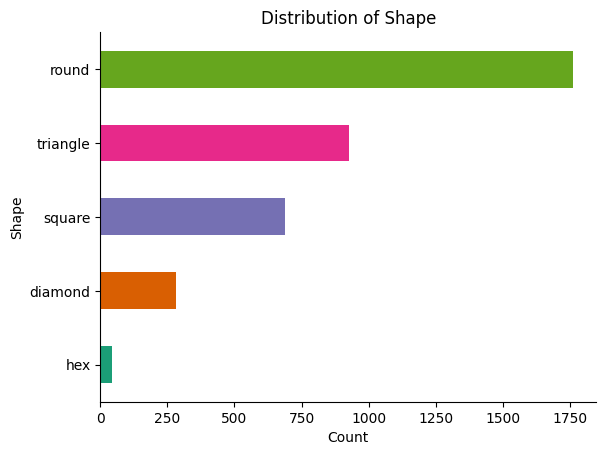

In [39]:
# Distribution of Shape dataframe
plot_distribution(shape_df, 'Shape')

In [40]:
# Explore the target variables
print("Class distribution in 'shape' data:")
print(shape_df['Shape'].value_counts())

Class distribution in 'shape' data:
Shape
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64


In [41]:
# Explore the shape data
shape_df.describe()

,Image Path,Shape
count,3699,3699
unique,3699,5
top,/content/drive/MyDrive/CML/trafficsigns_datase...,round
freq,1,1760


In [42]:
type_df

,Image Path,Type
0,/content/drive/MyDrive/CML/trafficsigns_datase...,continue
1,/content/drive/MyDrive/CML/trafficsigns_datase...,continue
2,/content/drive/MyDrive/CML/trafficsigns_datase...,continue
3,/content/drive/MyDrive/CML/trafficsigns_datase...,continue
4,/content/drive/MyDrive/CML/trafficsigns_datase...,continue
...,...,...
3694,/content/drive/MyDrive/CML/trafficsigns_datase...,noentry
3695,/content/drive/MyDrive/CML/trafficsigns_datase...,noentry
3696,/content/drive/MyDrive/CML/trafficsigns_datase...,noentry
3697,/content/drive/MyDrive/CML/trafficsigns_datase...,noentry


In [43]:
type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  3699 non-null   object
 1   Type        3699 non-null   object
dtypes: object(2)
memory usage: 57.9+ KB


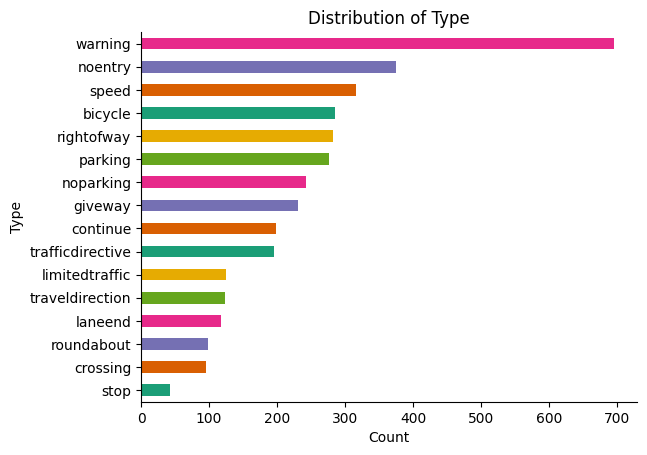

In [44]:
# Distribution of type dataframe
# Distribution of type dataframe
plot_distribution(type_df, 'Type')

In [45]:
print("Class distribution in 'type' data:")
print(type_df['Type'].value_counts())

Class distribution in 'type' data:
Type
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


**Key observation**:
There is a significant imbalance in the dataset, which could potentially lead to biases towards the more frequent classes. Methods such as class weighting and image augmentation could be crucial in addressing this issue. This also indicates that accuracy might not be the best metric to evaluate the model if balancing techniques are not implemented.

In [46]:
# Explore the type data
type_df.describe()

,Image Path,Type
count,3699,3699
unique,3699,16
top,/content/drive/MyDrive/CML/trafficsigns_datase...,warning
freq,1,695


In [47]:
# Check for missing values
print("Missing values in 'shape' data:", shape_df.isnull().sum().sum())
print("Missing values in 'type' data:", type_df.isnull().sum().sum())

Missing values in 'shape' data: 0
Missing values in 'type' data: 0


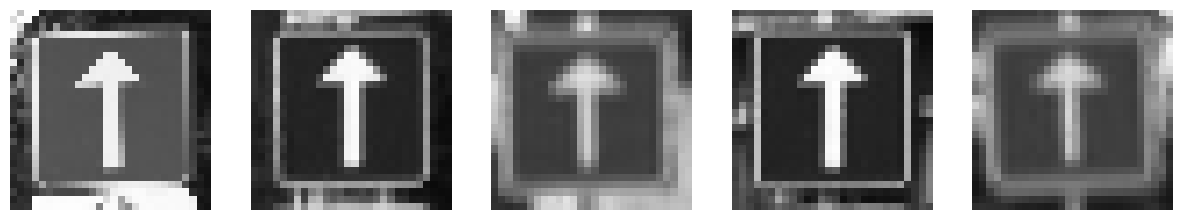

In [48]:
import cv2

# Function to display a grid of images
def display_sample_images(image_paths, n=5):
    """
    Display a grid of sample images.

    Parameters:
    image_paths (list): List of image paths.
    n (int): Number of images to display.

    Returns:
    None.
    """
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths[:n]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display sample images
sample_image_paths = shape_df['Image Path'].values
display_sample_images(sample_image_paths)

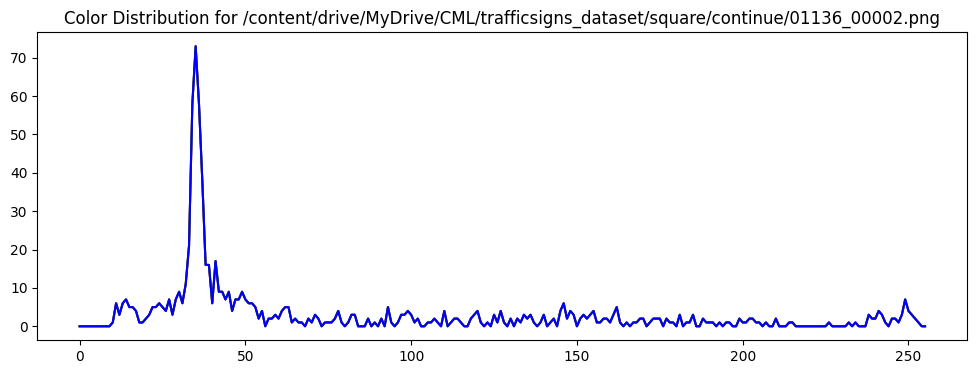

/content/drive/MyDrive/CML/trafficsigns_dataset/square/continue/01136_00002.png


In [49]:
def get_color_distribution(image_path):
    """
    Get the color distribution of an image.

    Parameters:
    image_path (str): The path to the image.

    Returns:
    None.
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.title('Color Distribution for ' + image_path)
    plt.show()

# Display color distribution for a sample image
get_color_distribution(sample_image_paths[1])
print(sample_image_paths[1])

The color scale value for a sample image suggest that it is gray scale. This is true for all the images.

### Hold-out validation

For complex neural networks,as suggestes in course hold out validation is carried out by splitting data into train (60%), validation (20%) and test (20%) data set.


In [50]:
# Split the data into train and test sets for shape
train_shape, test_shape = train_test_split(shape_df, test_size=0.2, random_state=42)

# Split the data into train and test sets for type
train_type, test_type = train_test_split(type_df, test_size=0.2, random_state=42)

# Split the data into train, test, and validation sets for shape
train_shape, val_shape = train_test_split(train_shape, test_size=0.25, random_state=42)

# Split the data into train, test, and validation sets for type
train_type, val_type = train_test_split(train_type, test_size=0.25, random_state=42)
print("Shape data\nTrain data : {}, Test Data: {}, Validtion Data: {}".format(len(train_shape), len(test_shape), len(val_shape)))
print("\nType data\nTrain data : {}, Test Data: {}, Validtion Data: {}".format(len(train_type), len(test_type), len(val_type)))



Shape data
Train data : 2219, Test Data: 740, Validtion Data: 740

Type data
Train data : 2219, Test Data: 740, Validtion Data: 740


# Model Development

## 1. MLP Models


### Model development utils - Part 1


In [51]:
# parameters

INPUT_DIM = (28, 28, 3)
HIDDEN_LAYER_DIM = 128

# NOTE: Our systems were struggling with heigher values, so we keep lower epochs value to check.
# NOTE: Most of the data saturate in minial epochs values, so 35 isn't bad for this case as we use SGD in all the algorithms.
# _epochs = 100
_epochs = 35

# All ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

#### Useful functions - Part 1

In [52]:
# Function 1


def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    """
    Plot the learning curve for a model.

    Parameters:
    train_loss (list): List of training loss values.
    val_loss (list): List of validation loss values.
    train_metric (list): List of training metric values.
    val_metric (list): List of validation metric values.
    """
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


# Function 2 - Cool thing about function is it can produce both agumented and normal images

def image_data_generator(data, target,datagen=None,_batch_size=28,_shuffle=True,augmentation_params=None):
    """
    Create a data generator from a dataframe.

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    target (str): The target column name for the labels.
    _batch_size (int): Batch size for the data generator. Default is 28.
    shuffle (bool): Whether to shuffle the data. Default is True.
    augmentation_params (dict or None): Dictionary containing augmentation parameters. If not None, the image agumentation will be applied.


    Returns:
    DirectoryIterator: A data generator for the given dataframe.
    """
    if datagen is None:
      datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    if augmentation_params is not None:
      print("Agumenting")
      datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', **augmentation_params)

    return datagen.flow_from_dataframe(
        dataframe=data,
        directory='./',
        x_col='Image Path',
        y_col=target,
        target_size=(28, 28),
        batch_size=_batch_size,
        class_mode='categorical',
        shuffle=_shuffle
    )


# Other functions - code provided in Useful functions - Part 2, where they are more relevant

## 1. Shape classification



In [53]:
base_mlp_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(len(set(test_shape.Shape)),activation='softmax')
])

In [54]:
set(test_shape.Shape)

{'diamond', 'hex', 'round', 'square', 'triangle'}

In [55]:
base_mlp_shape.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 128)               301184    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 301829 (1.15 MB)
Trainable params: 301829 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


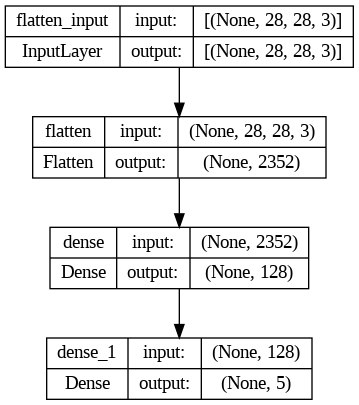

In [56]:
tf.keras.utils.plot_model(base_mlp_shape, show_shapes=True)

In [57]:
# Shape classification base model.

# Note - This MLP serves as the fundamental model for shape classification. It should not be mistaken for VGG base models, which are utilized to assess performance enhancements across different architectures.
# So, MLP base is the model over which any improved models will be compared.

base_mlp_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # False because argument was produced by a Softmax activation and thus does not represent logits
              metrics=['categorical_accuracy']) # Note categorical accuracy is selected. Main metrics will loss. Due to class imabalance, we won't use accuracy as main metic, at the end omce models are developed. F-1 score or other metrices from confusion matrix will be used to evaluate

In [58]:
# Generating train, validation, and test images

train_generator_shape = image_data_generator(train_shape, 'Shape' ,train_datagen,_shuffle=True)
validation_generator_shape = image_data_generator(val_shape, 'Shape' ,val_datagen,_shuffle=False)
test_generator_shape = image_data_generator(test_shape, 'Shape' ,test_datagen,_shuffle=False)

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [59]:
train_generator_shape.class_indices

{'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}

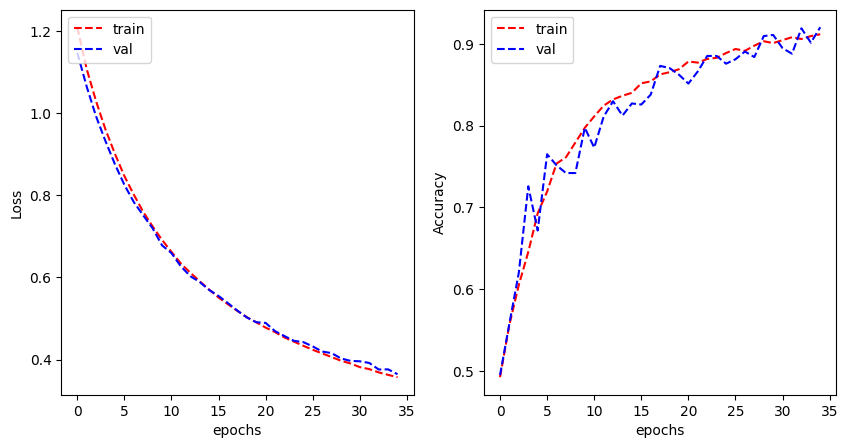

In [60]:
# fitting base model

history_mlp_shape = base_mlp_shape.fit(train_generator_shape, epochs=_epochs, validation_data=validation_generator_shape, verbose=0)

# plotting learning curve

plot_learning_curve(history_mlp_shape.history['loss'], history_mlp_shape.history['val_loss'],
                    history_mlp_shape.history['categorical_accuracy'], history_mlp_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [61]:
base_mlp_shape.evaluate(test_generator_shape) # Accuracy not a good evaluation for imbalanced class. Just see the loss, other metric evaluated at the end section

27/27 [==============================] - 4s 138ms/step - loss: 0.3871 - categorical_accuracy: 0.8986


[0.38705024123191833, 0.8986486196517944]

## 2. Type classification (MLP)


In [62]:
base_mlp_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(len(set(test_type.Type)),activation='softmax')
])

In [63]:
base_mlp_type.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               301184    
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
Total params: 303248 (1.16 MB)
Trainable params: 303248 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


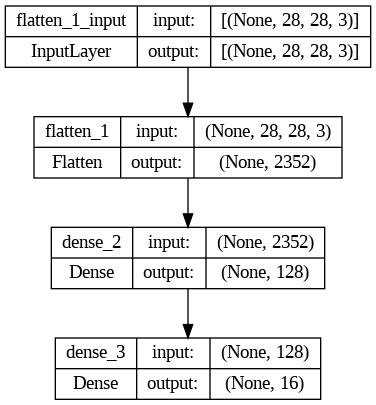

In [64]:
tf.keras.utils.plot_model(base_mlp_type, show_shapes=True)

In [66]:
base_mlp_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), ## False because argument was produced by a Softmax activation and thus does not represent logits
              metrics=['categorical_accuracy'])


In [67]:
# Generating 'Type' image data

train_generator_type = image_data_generator(train_type, 'Type' ,train_datagen,_shuffle=True)
validation_generator_type = image_data_generator(val_type, 'Type' ,val_datagen,_shuffle=False)
test_generator_type = image_data_generator(test_type, 'Type' ,test_datagen,_shuffle=False)

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [68]:
train_generator_type.class_indices

{'bicycle': 0,
 'continue': 1,
 'crossing': 2,
 'giveway': 3,
 'laneend': 4,
 'limitedtraffic': 5,
 'noentry': 6,
 'noparking': 7,
 'parking': 8,
 'rightofway': 9,
 'roundabout': 10,
 'speed': 11,
 'stop': 12,
 'trafficdirective': 13,
 'traveldirection': 14,
 'warning': 15}

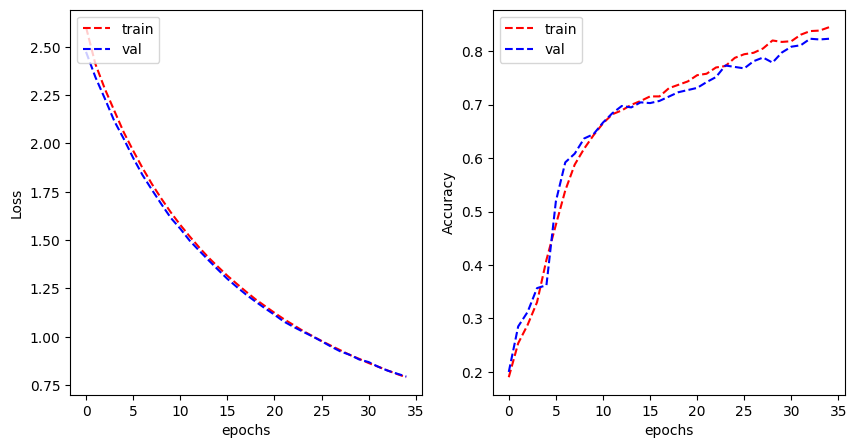

In [69]:
# fitting base model
history_mlp_type = base_mlp_type.fit(train_generator_type, epochs=_epochs, validation_data=validation_generator_type, verbose=0)
plot_learning_curve(history_mlp_type.history['loss'], history_mlp_type.history['val_loss'],
                    history_mlp_type.history['categorical_accuracy'], history_mlp_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [70]:
base_mlp_type.evaluate(test_generator_type)

27/27 [==============================] - 4s 129ms/step - loss: 0.8662 - categorical_accuracy: 0.8068


[0.8662360310554504, 0.8067567348480225]

In [72]:
# Saving base models

base_mlp_shape.save('/content/drive/MyDrive/CML/saved_models/base_mlp_shape')
base_mlp_type.save('/content/drive/MyDrive/CML/saved_models/base_mlp_type')


# Incremental Changes to MLP model

**Key Observations**: Key observations from previous model:

1. The primary issue identified was imbalanced data classes.

2. Confusing outer edges made it challenging to identify shapes.

3. Difficulty in locating the inner edge for more complex classifications suggests that advanced architectures may be needed for type classification.


### Model development utils - Part 2




In [73]:
# class weights

# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

cw_shape = class_weight.compute_class_weight('balanced',classes= np.unique(train_generator_shape.classes),  y=np.array(train_generator_shape.classes))

class_weight_dict_shape = {i: weight for i, weight in enumerate(cw_shape)}


# for type

cw_type = class_weight.compute_class_weight('balanced',classes= np.unique(train_generator_type.classes),  y=np.array(train_generator_type.classes))
class_weight_dict_type = {i: weight for i, weight in enumerate(cw_type)}


In [74]:
class_weight_dict_shape, class_weight_dict_type

({0: 2.4384615384615387,
  1: 16.437037037037037,
  2: 0.4147663551401869,
  3: 1.137948717948718,
  4: 0.8069090909090909},
 {0: 0.7662292817679558,
  1: 1.1853632478632479,
  2: 2.719362745098039,
  3: 1.042763157894737,
  4: 1.98125,
  5: 1.670933734939759,
  6: 0.5926816239316239,
  7: 0.9698426573426573,
  8: 0.9124177631578947,
  9: 0.7620192307692307,
  10: 2.1669921875,
  11: 0.741644385026738,
  12: 5.136574074074074,
  13: 1.3731435643564356,
  14: 1.8011363636363635,
  15: 0.332583932853717})

In [75]:
# Model development utils - Part 2 cntd


# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001,baseline=None,restore_best_weights=True)


# Data agumentation parameters
augmentation_params = {
    'rotation_range': 40,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}


# agumented images

train_generator_shape_aug= image_data_generator(train_shape, 'Shape',_shuffle=True,augmentation_params=augmentation_params)
train_generator_type_aug= image_data_generator(train_type, 'Type',_shuffle=True,augmentation_params=augmentation_params)

Agumenting
Found 2219 validated image filenames belonging to 5 classes.
Agumenting
Found 2219 validated image filenames belonging to 16 classes.


### 1. Shape classification MLP improvements

In [76]:
# Adding class weights

mlp_weighted_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(len(set(test_shape.Shape)),activation='softmax')
])

mlp_weighted_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_shape_mlp_weights = mlp_weighted_shape.fit(train_generator_shape, epochs=_epochs, validation_data=validation_generator_shape, verbose=0, class_weight=class_weight_dict_shape)

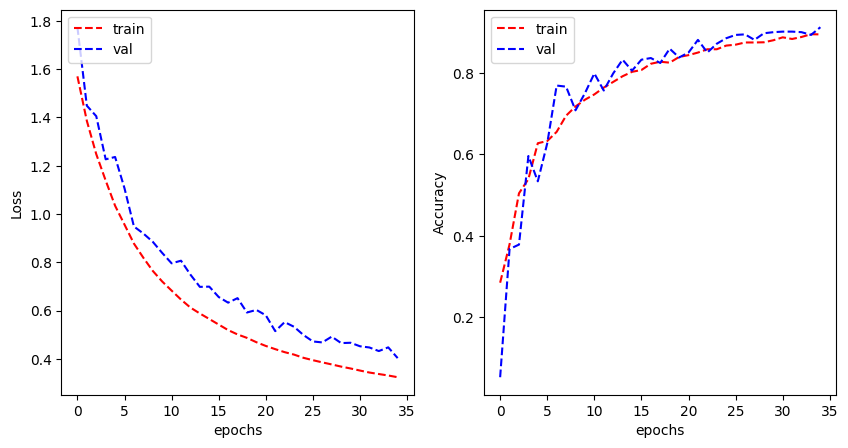

In [77]:
plot_learning_curve(history_shape_mlp_weights.history['loss'], history_shape_mlp_weights.history['val_loss'],
                    history_shape_mlp_weights.history['categorical_accuracy'], history_shape_mlp_weights.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

<ipython-input-78-224d0f02c9cc>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mlp_relu_reg_shape = mlp_relu_reg_shape.fit_generator(train_generator_shape, epochs=_epochs, validation_data=validation_generator_shape, verbose=0)


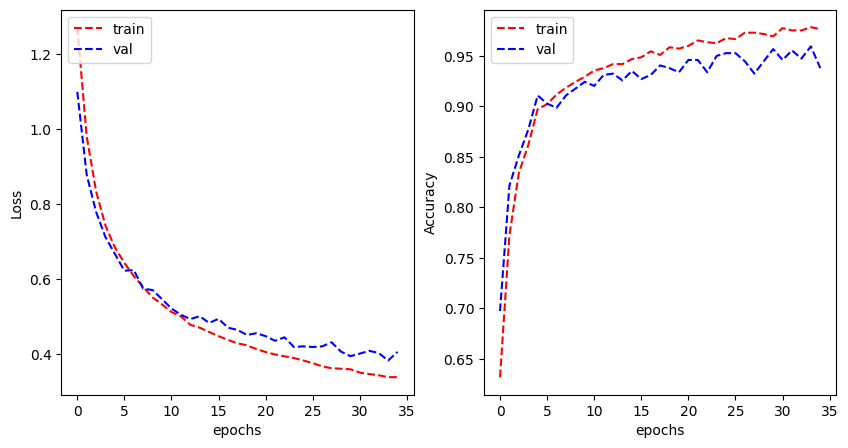

In [78]:
# relu activation with regularization.
reg_lambda = 0.001
mlp_relu_reg_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(len(set(test_shape.Shape)),activation='softmax')
    ])

mlp_relu_reg_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_mlp_relu_reg_shape = mlp_relu_reg_shape.fit_generator(train_generator_shape, epochs=_epochs, validation_data=validation_generator_shape, verbose=0)

plot_learning_curve(history_mlp_relu_reg_shape.history['loss'], history_mlp_relu_reg_shape.history['val_loss'],
                    history_mlp_relu_reg_shape.history['categorical_accuracy'], history_mlp_relu_reg_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

<ipython-input-79-860e7b3eded6>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mlp_relu_reg_aug_shape = mlp_relu_reg_aug_shape.fit_generator(train_generator_shape_aug, epochs=_epochs, validation_data=validation_generator_shape, verbose=0)


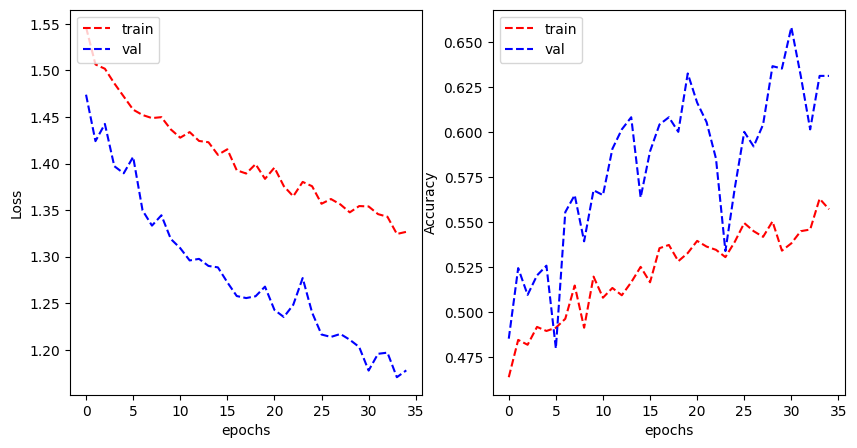

In [79]:
mlp_relu_reg_aug_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(len(set(test_shape.Shape)),activation='softmax')
    ])

mlp_relu_reg_aug_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_mlp_relu_reg_aug_shape = mlp_relu_reg_aug_shape.fit_generator(train_generator_shape_aug, epochs=_epochs, validation_data=validation_generator_shape, verbose=0)

plot_learning_curve(history_mlp_relu_reg_aug_shape.history['loss'], history_mlp_relu_reg_aug_shape.history['val_loss'],
                    history_mlp_relu_reg_aug_shape.history['categorical_accuracy'], history_mlp_relu_reg_aug_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [80]:
# saving models - do afte re-running
mlp_weighted_shape.save('/content/drive/MyDrive/CML/saved_models/mlp_weighted_shape')
mlp_relu_reg_shape.save('/content/drive/MyDrive/CML/saved_models/mlp_relu_reg_shape')
# mlp_relu_reg_aug_shape.save('/content/drive/MyDrive/CML/saved_models/mlp_relu_reg_aug_shape')


### 1. Type classification MLP improvements

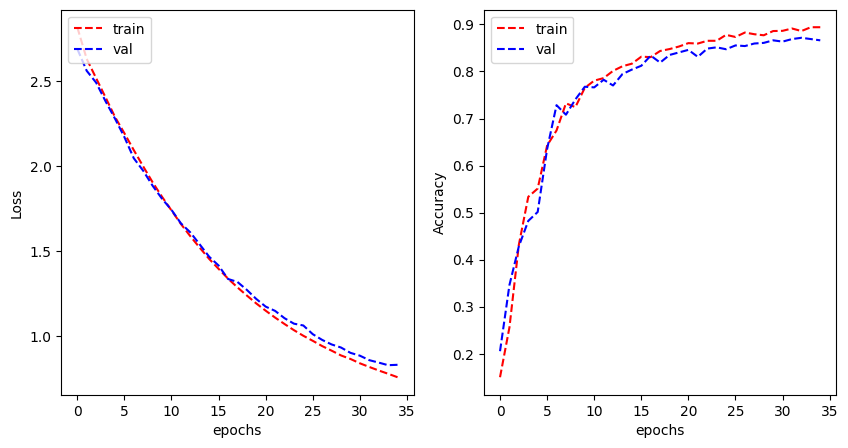

In [85]:
# Adding class weights

mlp_weighted_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(len(set(test_type.Type)),activation='softmax')
])

mlp_weighted_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_type_mlp_weights = mlp_weighted_type.fit(train_generator_type, epochs=_epochs, validation_data=validation_generator_type, verbose=0, class_weight=class_weight_dict_type)

plot_learning_curve(history_type_mlp_weights.history['loss'], history_type_mlp_weights.history['val_loss'],
                    history_type_mlp_weights.history['categorical_accuracy'], history_type_mlp_weights.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

<ipython-input-86-0f0fe64087b3>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mlp_relu_reg_type = mlp_relu_reg_type.fit_generator(train_generator_type, epochs=_epochs, validation_data=validation_generator_type, verbose=0)


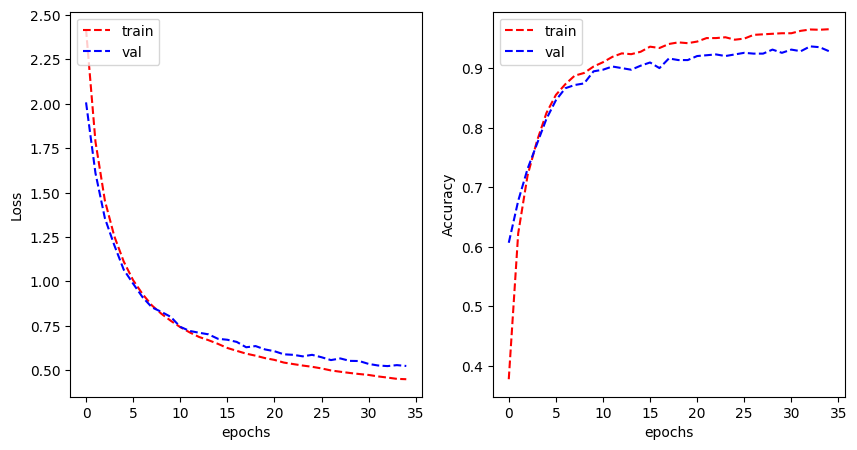

In [86]:
# relu activation with regularization.


mlp_relu_reg_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(len(set(test_type.Type)),activation='softmax')
    ])

mlp_relu_reg_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy', 'Precision', 'Recall'])

# fitting model
history_mlp_relu_reg_type = mlp_relu_reg_type.fit_generator(train_generator_type, epochs=_epochs, validation_data=validation_generator_type, verbose=0)

# plotting

plot_learning_curve(history_mlp_relu_reg_type.history['loss'], history_mlp_relu_reg_type.history['val_loss'],
                    history_mlp_relu_reg_type.history['categorical_accuracy'], history_mlp_relu_reg_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

<ipython-input-87-9a1bbefa2b2f>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mlp_relu_reg_aug_type = mlp_relu_reg_aug_type.fit_generator(train_generator_type_aug, epochs=_epochs, validation_data=validation_generator_type, verbose=0)


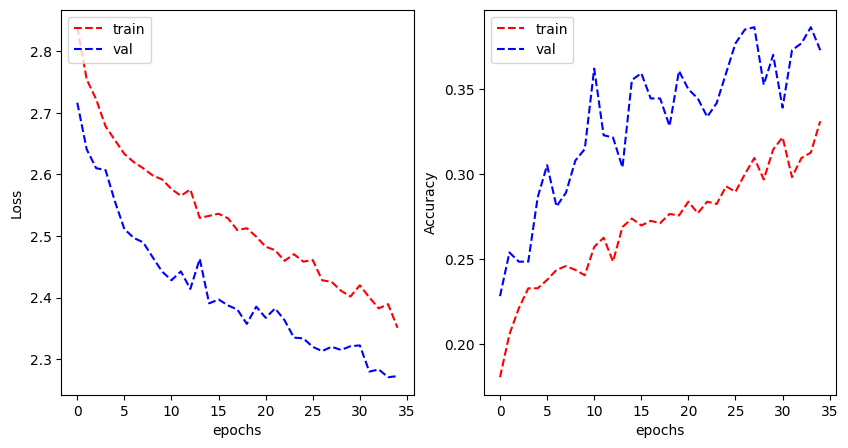

In [87]:
# On agumented data


mlp_relu_reg_aug_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(len(set(test_type.Type)),activation='softmax')
    ])

mlp_relu_reg_aug_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy', 'Precision', 'Recall'])

# fitting model
history_mlp_relu_reg_aug_type = mlp_relu_reg_aug_type.fit_generator(train_generator_type_aug, epochs=_epochs, validation_data=validation_generator_type, verbose=0)

# plotting

plot_learning_curve(history_mlp_relu_reg_aug_type.history['loss'], history_mlp_relu_reg_aug_type.history['val_loss'],
                    history_mlp_relu_reg_aug_type.history['categorical_accuracy'], history_mlp_relu_reg_aug_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [89]:
# saving models - do afte re-running
mlp_weighted_type.save('/content/drive/MyDrive/CML/saved_models/mlp_weighted_type')
mlp_relu_reg_type.save('/content/drive/MyDrive/CML/saved_models/mlp_relu_reg_type')
# mlp_relu_reg_aug_type.save('/content/drive/MyDrive/CML/saved_models/mlp_relu_reg_aug_type')

## 1. VGG Models

#### Useful functions - Part 2

In [90]:
# Let's try VGG Base to check if just changing model improved the score

# Function 1
def VGG_Model(input_dim, output_class):
  """
  Create VGG model for image classification.

  Parameters:
  output_class (int): Number of classes for classification.

  Returns:
  VGG model.
  """
  VGG_model = tf.keras.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=input_dim),
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 2
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 3
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output_class, activation = "softmax"),
      ])
  return VGG_model

# Function 2

def VGG_Model_reg(input_dim,reg_lambda,output_class):
  """
  Create VGG model for image classification.

  Parameters:
  input_dim (tuple): Input dimensions for the model.
  reg_hyp (float): Regularization hyperparameter.
  output_class (int): Number of classes for classification.

  Returns:
  Regularized VGG model.
  """
  VGG_model_reg = tf.keras.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu',  kernel_regularizer = tf.keras.regularizers.L2(reg_lambda),padding='same', input_shape=input_dim),
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 2
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 3
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Dense(output_class, activation = "softmax"),
      ])

  VGG_model_reg.compile(optimizer='SGD',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['categorical_accuracy'])
  return VGG_model_reg


# Function 3

def VGG_Model_reg_drop(input_dim,dropout_rate,output_class,reg_lambda=0.0001):
  """
  Create VGG model for image classification.

  Parameters:
  input_dim (tuple): Input dimensions for the model.
  reg_hyp (float): Regularization value from previous step.
  dropout_rate: Hyperparameter for dropout layer.
  output_class (int): Number of classes for classification.

  Returns:
  VGG model.
  """
  VGG_model_reg_dropout = tf.keras.Sequential([
      # Block 1
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu',  kernel_regularizer = tf.keras.regularizers.L2(reg_lambda),padding='same', input_shape=input_dim),
      tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 2
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Block 3
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(reg_lambda)),
      tf.keras.layers.Dropout(rate = dropout_rate),
      tf.keras.layers.Dense(output_class, activation = "softmax"),
      ])

  VGG_model_reg_dropout.compile(optimizer='SGD',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['categorical_accuracy'])
  return VGG_model_reg_dropout

## 1. Shape classification using VGG and improvements



In [91]:
# Base for vgg

base_vgg_shape = VGG_Model(INPUT_DIM, len(set(test_shape.Shape)))

In [92]:
base_vgg_shape.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 28)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                

In [93]:
base_vgg_shape.compile(optimizer='SGD',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['categorical_accuracy'])

history_vgg_shape = base_vgg_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)


<ipython-input-93-084fd60693ed>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_shape = base_vgg_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)


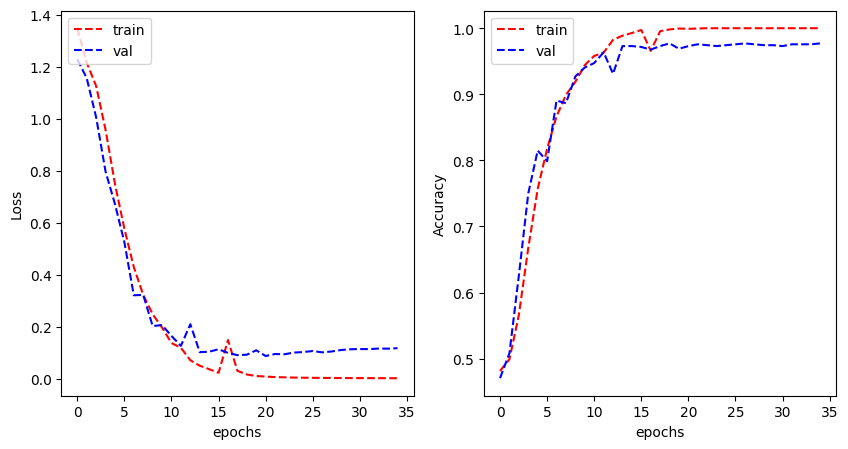

In [94]:
plot_learning_curve(history_vgg_shape.history['loss'], history_vgg_shape.history['val_loss'],
                    history_vgg_shape.history['categorical_accuracy'], history_vgg_shape.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

#### Incremental changes

In [ ]:
#kt.HyperParameters() --->https://keras.io/guides/keras_tuner/getting_started/

In [95]:
len(set(test_shape.Shape))

5

In [96]:
# https://keras.io/guides/keras_tuner/getting_started/


def build_model_reg_shape(hp):
  """
  Function to tune regularization hyperparameter for shape data
  """
  reg_lambda = hp.Choice('reg_lambda',[0.0001,0.001,0.01,0.1])
  model = VGG_Model_reg(INPUT_DIM,reg_lambda,len(set(test_shape.Shape)))
  return model

build_model_reg_shape(kt.HyperParameters())

In [97]:
reg_tune_shape = kt.RandomSearch(build_model_reg_shape,
                                 objective='val_loss',
                                 max_trials=3,
                                 overwrite=True)

reg_tune_shape.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [98]:
# due to computatinal limitations -  is set at lower value.
# Also, we see most of our points get satuarated at lower epochs value previously

reg_tune_shape.search(train_generator_shape, epochs= 5, verbose = 0, validation_data=validation_generator_shape)

In [99]:
reg_tune_shape.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
reg_lambda: 0.0001
Score: 0.6352892518043518

Trial 1 summary
Hyperparameters:
reg_lambda: 0.01
Score: 5.682295799255371

Trial 2 summary
Hyperparameters:
reg_lambda: 0.1
Score: 13.058466911315918


In [101]:
#0.0001 has lowest loss value, lets check

best_model_reg_shape = reg_tune_shape.get_best_models()[0]
best_hp_reg_shape = reg_tune_shape.get_best_hyperparameters()[0]

print(best_hp_reg_shape['reg_lambda'])

0.0001


In [102]:
best_model_reg_shape.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 28)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                   

In [103]:
vgg_reg_shape = reg_tune_shape.hypermodel.build(best_hp_reg_shape)

history_vgg_reg_shape = vgg_reg_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)

<ipython-input-103-40a7249cdadf>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_shape = vgg_reg_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)


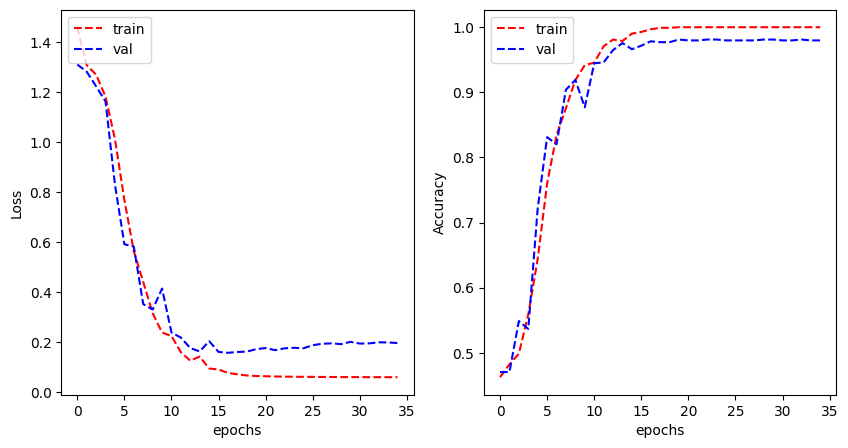

In [104]:
plot_learning_curve(history_vgg_reg_shape.history['loss'], history_vgg_reg_shape.history['val_loss'],
                    history_vgg_reg_shape.history['categorical_accuracy'], history_vgg_reg_shape.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

In [105]:
# drop out validation

def build_model_reg_drop_shape(hp):
  """
  Function to tune regularization hyperparameter for shape data
  """
  dropout_rate = hp.Choice('dropout_rate',[0.2,0.3,0.4,0.5])
  model = VGG_Model_reg_drop(INPUT_DIM,dropout_rate,len(set(test_shape.Shape)))
  return model

build_model_reg_drop_shape(kt.HyperParameters())

In [106]:
drop_tune_shape = kt.RandomSearch(build_model_reg_drop_shape,
                                 objective='val_loss',
                                 max_trials=3,
                                 overwrite=True)

drop_tune_shape.search_space_summary()

Search space summary
Default search space size: 1
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}


In [107]:
drop_tune_shape.search(train_generator_shape, epochs= 5, verbose = 0, validation_data=validation_generator_shape)

In [108]:

best_model_drop_shape = drop_tune_shape.get_best_models()[0]
best_hp_drop_shape = drop_tune_shape.get_best_hyperparameters()[0]

print(best_hp_drop_shape['dropout_rate'])

0.3


In [109]:
# 0.3 is seleted as drop out rate
vgg_reg_drop_shape = drop_tune_shape.hypermodel.build(best_hp_drop_shape)

history_vgg_reg_drop_shape = vgg_reg_drop_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)

<ipython-input-109-452425a5070d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_drop_shape = vgg_reg_drop_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=_epochs,verbose=0)


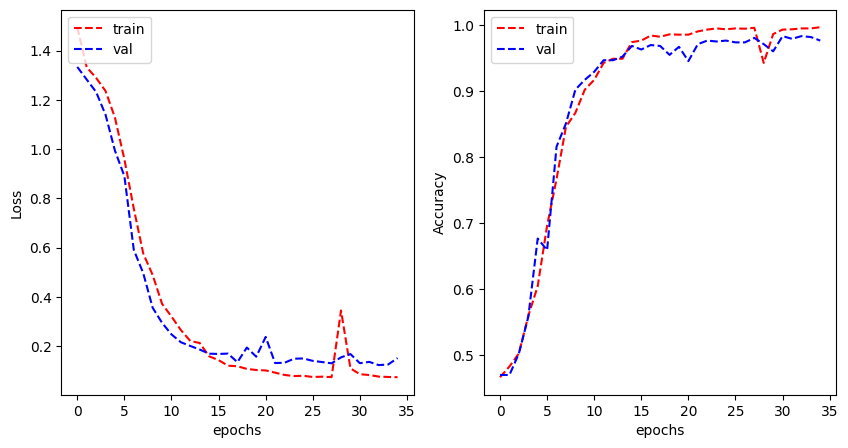

In [110]:
plot_learning_curve(history_vgg_reg_drop_shape.history['loss'], history_vgg_reg_drop_shape.history['val_loss'],
                    history_vgg_reg_drop_shape.history['categorical_accuracy'], history_vgg_reg_drop_shape.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

In [111]:
# early stopping

history_vgg_reg_drop_early_shape = vgg_reg_drop_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=35,verbose=0, callbacks=[early_stopping])

<ipython-input-111-a47186de6492>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_drop_early_shape = vgg_reg_drop_shape.fit_generator(train_generator_shape, validation_data=validation_generator_shape, epochs=35,verbose=0, callbacks=[early_stopping])


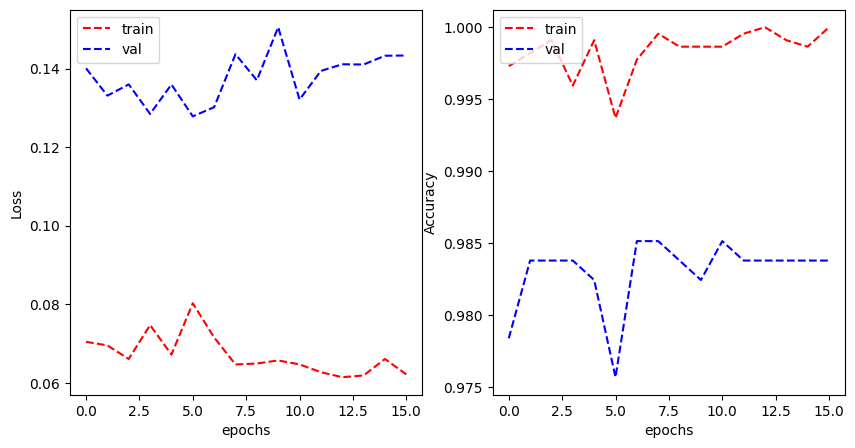

In [112]:
plot_learning_curve(history_vgg_reg_drop_early_shape.history['loss'], history_vgg_reg_drop_early_shape.history['val_loss'],
                    history_vgg_reg_drop_early_shape.history['categorical_accuracy'], history_vgg_reg_drop_early_shape.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

<ipython-input-113-a695496a04bb>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_early_aug_drop_shape = vgg_reg_drop_aug_shape.fit_generator(train_generator_shape_aug, validation_data=validation_generator_shape, epochs=35,verbose=0, callbacks=[early_stopping])


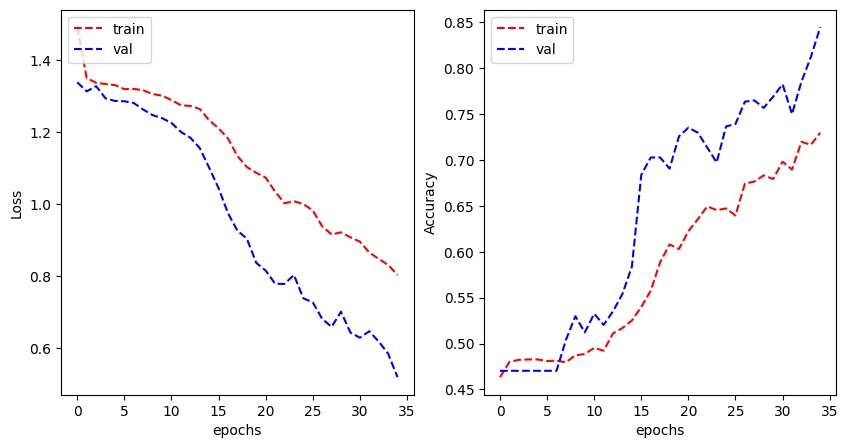

In [113]:
# for agumented data


vgg_reg_drop_aug_shape = drop_tune_shape.hypermodel.build(best_hp_drop_shape)

history_vgg_reg_early_aug_drop_shape = vgg_reg_drop_aug_shape.fit_generator(train_generator_shape_aug, validation_data=validation_generator_shape, epochs=35,verbose=0, callbacks=[early_stopping])

plot_learning_curve(history_vgg_reg_early_aug_drop_shape.history['loss'], history_vgg_reg_early_aug_drop_shape.history['val_loss'],
                    history_vgg_reg_early_aug_drop_shape.history['categorical_accuracy'], history_vgg_reg_early_aug_drop_shape.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

In [116]:

# selected only early stopped
# base_vgg_shape.save('/content/drive/MyDrive/CML/saved_models/base_vgg_shape')

vgg_reg_drop_shape.save('/content/drive/MyDrive/CML/saved_models/vgg_reg_drop_shape')


## 1. Type classification using VGG and improvements




<ipython-input-117-cf8b12f19034>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_type = base_vgg_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=10,verbose=0)
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


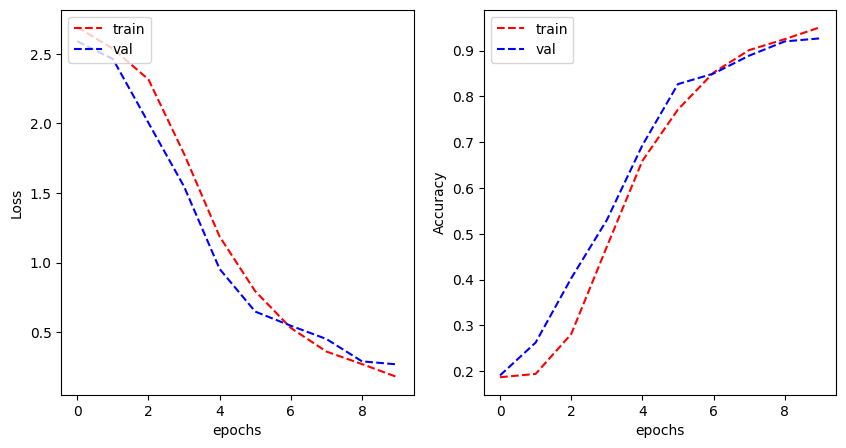

In [117]:
# Base

base_vgg_type = VGG_Model(INPUT_DIM, len(set(test_type.Type)))
base_vgg_type.compile(optimizer='SGD',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['categorical_accuracy'])

history_vgg_type = base_vgg_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=10,verbose=0)

plot_learning_curve(history_vgg_type.history['loss'], history_vgg_type.history['val_loss'],
                    history_vgg_type.history['categorical_accuracy'], history_vgg_type.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')

In [118]:
def build_model_reg_type(hp):
  """
  Function to tune regularization hyperparameter for type data
  """
  reg_lambda = hp.Choice('reg_lambda',[0.0001,0.001,0.01,0.1])
  model = VGG_Model_reg(INPUT_DIM,reg_lambda,len(set(test_type.Type)))
  return model

build_model_reg_type(kt.HyperParameters())


In [119]:

reg_tune_type = kt.RandomSearch(build_model_reg_type,
                                 objective='val_loss',
                                 max_trials=3,
                                 overwrite=True)

reg_tune_type.search_space_summary()

Search space summary
Default search space size: 1
reg_lambda (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [120]:
# WARNING: Takes few minutes to run

reg_tune_type.search(train_generator_type, epochs= 5, verbose = 0, validation_data=validation_generator_type)


In [121]:
best_model_reg_type = reg_tune_type.get_best_models()[0]
best_hp_reg_type = reg_tune_type.get_best_hyperparameters()[0]

print(best_hp_reg_type['reg_lambda'])

0.0001


<ipython-input-122-8d3ba607e664>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_type = vgg_reg_type_model.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=_epochs,verbose=0)


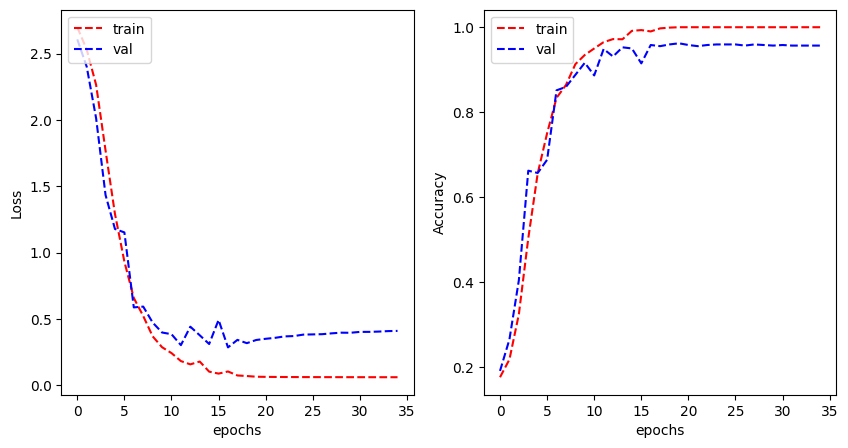

In [122]:

# WARNING: Need long to run.

vgg_reg_type_model = reg_tune_type.hypermodel.build(best_hp_reg_type)

history_vgg_reg_type = vgg_reg_type_model.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=_epochs,verbose=0)

plot_learning_curve(history_vgg_reg_type.history['loss'], history_vgg_reg_type.history['val_loss'],
                    history_vgg_reg_type.history['categorical_accuracy'], history_vgg_reg_type.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')


In [123]:

def build_model_reg_drop_type(hp):
  """
  Function to tune regularization hyperparameter for shape data
  """
  dropout_rate = hp.Choice('dropout_rate',[0.2,0.3,0.4,0.5])
  model = VGG_Model_reg_drop(INPUT_DIM,dropout_rate,len(set(test_type.Type)))
  return model

build_model_reg_drop_type(kt.HyperParameters())

In [124]:
drop_tune_type = kt.RandomSearch(build_model_reg_drop_type,
                                 objective='val_loss',
                                 max_trials=3,
                                 overwrite=True)

drop_tune_type.search_space_summary()

Search space summary
Default search space size: 1
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}


In [125]:
# WARNING: Takes few minutes to run
drop_tune_type.search(train_generator_type, epochs= 5, verbose = 0, validation_data=validation_generator_type)


In [126]:
best_model_drop_type = drop_tune_type.get_best_models()[0]
best_hp_drop_type = drop_tune_type.get_best_hyperparameters()[0]

print(best_hp_drop_type['dropout_rate'])

0.4


<ipython-input-128-898fd57a967f>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_drop_type = vgg_reg_drop_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=35,verbose=0, callbacks=[early_stopping])


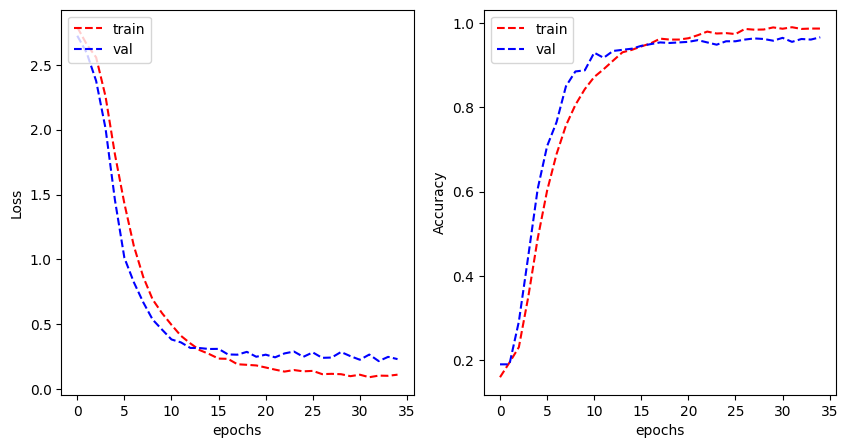

In [128]:
# WARNING: Takes longer to run
# Best drop = 0.4

vgg_reg_drop_type = drop_tune_type.hypermodel.build(best_hp_drop_type)

history_vgg_reg_drop_type = vgg_reg_drop_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=35,verbose=0, callbacks=[early_stopping])

plot_learning_curve(history_vgg_reg_drop_type.history['loss'], history_vgg_reg_drop_type.history['val_loss'],
                    history_vgg_reg_drop_type.history['categorical_accuracy'], history_vgg_reg_drop_type.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')


In [ ]:
# early stopping

# history_vgg_reg_drop_early_type = vgg_reg_drop_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=35,verbose=0, callbacks=[early_stopping])

<ipython-input-129-6cad6dc26c15>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg_reg_drop_type = vgg_reg_drop_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=35,verbose=0,callbacks=[early_stopping])


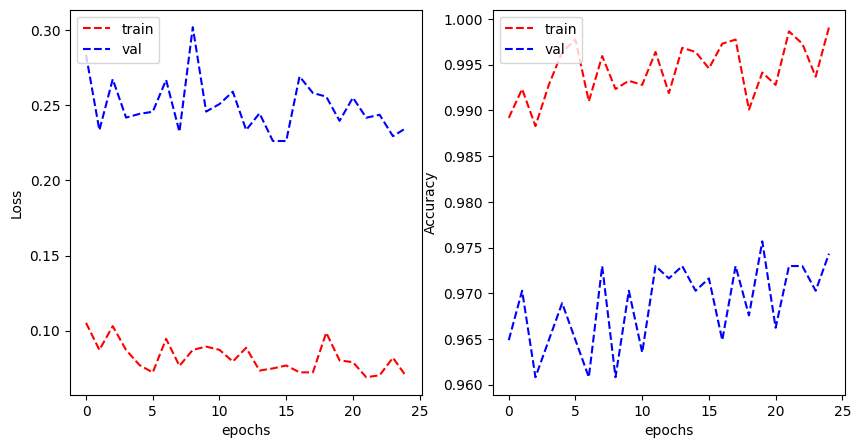

In [129]:
# augumented data

vgg_reg_drop_aud_type = drop_tune_type.hypermodel.build(best_hp_drop_type)

history_vgg_reg_drop_type = vgg_reg_drop_type.fit_generator(train_generator_type, validation_data=validation_generator_type, epochs=35,verbose=0,callbacks=[early_stopping])

plot_learning_curve(history_vgg_reg_drop_type.history['loss'], history_vgg_reg_drop_type.history['val_loss'],
                    history_vgg_reg_drop_type.history['categorical_accuracy'], history_vgg_reg_drop_type.history['val_categorical_accuracy'],
                    metric_name = 'Accuracy')



In [ ]:
# for agumented data

# vgg_reg_drop_aug_type = VGG_Model_reg_drop(INPUT_DIM,0.3,len(set(test_type.Type)))

# history_vgg_reg_drop_aug_type=  vgg_reg_drop_aug_type.fit_generator(train_generator_type_aug, validation_data=validation_generator_type, epochs=_epochs,verbose=0)
# plot_learning_curve(history_vgg_reg_drop_aug_type.history['loss'], history_vgg_reg_drop_aug_type.history['val_loss'],
#                     history_vgg_reg_drop_aug_type.history['categorical_accuracy'], history_vgg_reg_drop_aug_type.history['val_categorical_accuracy'],
#                     metric_name = 'Accuracy')


In [130]:
base_vgg_type.save('/content/drive/MyDrive/CML/saved_models/base_vgg_type')
vgg_reg_drop_type.save('/content/drive/MyDrive/CML/saved_models/vgg_reg_drop_type')

vgg_reg_drop_aud_type.save('/content/drive/MyDrive/CML/saved_models/vgg_reg_drop_aud_type')


Need to do validation


1. load saved data types. Do not re run previous chunks. Just import models and load them. Tooks whole night to complie all models. If accidenlty re-run do not commit to main branch or your branch. Just re open from github

2. Do of base_vgg_type, vgg_reg_drop_type, vgg_reg_drop_aud_type, mlp_relu_reg_type, vgg_reg_drop_shape, mlp_relu_reg_shape, mlp_relu_reg_type, and 2 base mlp

Need to find test data, need 10 clicked pictures